## Recommender Systems

### [TABLE OF CONTENTS](#toc)

#### [1. Install Requirements](#install)

#### [2. Import Libraries](#import)

#### [3. Revisiting Vectorization and Word Embeddings](#w2v)

#### [4. Deep Learning for Recommender Systems](#dlrm)

#### [5. LLM based Recommender Systems](#llm)

#### [6. Results Comparision](#results)


<a id='install'></a>

#### 1. Install requirements

In [4]:
!pip install -r requirements.txt

<a id='import'></a>

#### 2. Import Libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import csv
import re
import math
from tqdm import tqdm
import keras

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from sklearn.neighbors import KNeighborsClassifier

import gensim
from gensim.models import Word2Vec
import gensim.downloader as api

from IPython.display import SVG, display
from urllib.request import urlretrieve
import zipfile
import collections

import faiss
import requests

%matplotlib inline

<a id='w2v'></a>

#### 3. Revisiting Vectorization and Word Embeddings

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    wv = api.load('glove-twitter-25')

In [16]:
wv.most_similar('twitter')

[('facebook', 0.948005199432373),
 ('tweet', 0.9403423070907593),
 ('fb', 0.9342358708381653),
 ('instagram', 0.9104824066162109),
 ('chat', 0.8964964747428894),
 ('hashtag', 0.8885937333106995),
 ('tweets', 0.8878158330917358),
 ('tl', 0.8778461217880249),
 ('link', 0.8778210878372192),
 ('internet', 0.8753897547721863)]

In [18]:
wv.most_similar('dance')

[('song', 0.9117437601089478),
 ('music', 0.9095534086227417),
 ('pop', 0.9094172120094299),
 ('movie', 0.9060158133506775),
 ('dancing', 0.9013945460319519),
 ('mix', 0.8989439606666565),
 ('crew', 0.8982195258140564),
 ('tune', 0.8931055665016174),
 ('band', 0.8917027115821838),
 ('rock', 0.8815890550613403)]

In [20]:
wv.most_similar('great')

[('amazing', 0.9460338950157166),
 ('today', 0.9385192394256592),
 ('good', 0.93785160779953),
 ('fantastic', 0.9372739791870117),
 ('special', 0.9276166558265686),
 ('more', 0.9249935150146484),
 ('our', 0.9248101115226746),
 ('day', 0.92476886510849),
 ('this', 0.9239132404327393),
 ('awesome', 0.9237233996391296)]

<a id='dlrm'></a>

#### 4. Deep Learning for Recommender Systems

In [85]:
# Download MovieLens data.
print("Downloading movielens data...")
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: int(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: int(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: int(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: int(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [87]:

# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [277]:
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,...,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,1997,49,M,writer,55105
1,185,301,3.0,891717742,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,...,0,0,1,0,0,1997,39,F,executive,00000
2,21,376,1.0,878887116,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,...,0,0,0,0,0,1994,25,M,writer,40206
3,243,50,2.0,880606923,Legends of the Fall (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,0,...,1,0,0,1,1,1994,28,M,technician,80525
4,165,345,1.0,886397596,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,...,0,0,0,0,0,1997,47,M,educator,55113


In [279]:
movielens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             100000 non-null  int64  
 1   movie_id            100000 non-null  int64  
 2   rating              100000 non-null  float64
 3   unix_timestamp      100000 non-null  int64  
 4   title               100000 non-null  object 
 5   release_date        99991 non-null   object 
 6   video_release_date  0 non-null       float64
 7   imdb_url            99987 non-null   object 
 8   genre_unknown       100000 non-null  int64  
 9   Action              100000 non-null  int64  
 10  Adventure           100000 non-null  int64  
 11  Animation           100000 non-null  int64  
 12  Children            100000 non-null  int64  
 13  Comedy              100000 non-null  int64  
 14  Crime               100000 non-null  int64  
 15  Documentary         100000 non-null

In [281]:
min_rating = min(movielens["rating"])
max_rating = max(movielens["rating"])
print(min_rating, max_rating)

1.0 5.0


In [283]:
train, test = train_test_split(movielens, test_size=0.1)

In [285]:
ROW_COUNT = train.shape[0]
ROW_COUNT

90000

In [287]:
EMBEDDING_SIZE = 10
NUM_USERS = movielens['user_id'].nunique()
NUM_MOVIES = movielens['movie_id'].nunique()

print(NUM_USERS, NUM_MOVIES)

943 1682


In [288]:
train.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,...,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
95813,488,875,2.0,891447218,Money Talks (1997),22-Aug-1997,NaN,http://us.imdb.com/M/title-exact?Money+Talks+(...,0,1,...,0,0,0,0,0,1997,55,M,other,45218
84312,312,228,3.0,891028241,Star Trek III: The Search for Spock (1984),01-Jan-1984,NaN,http://us.imdb.com/M/title-exact?Star%20Trek%2...,0,1,...,0,1,0,0,0,1984,41,M,marketing,60035
36957,477,27,3.0,889395655,Apollo 13 (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Apollo%2013%2...,0,1,...,0,0,1,0,0,1995,29,M,other,10019
74949,471,230,5.0,875980418,Batman Returns (1992),01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Batman%20Retu...,0,1,...,0,0,0,0,0,1992,24,M,student,87544
6436,263,515,5.0,886123655,Local Hero (1983),01-Jan-1983,NaN,http://us.imdb.com/M/title-exact?Local%20Hero%...,0,0,...,0,0,0,0,0,1983,36,F,writer,90064


In [291]:
UNIQUE_MOVIE_IDS = movielens['movie_id'].unique()

In [330]:
# Define the Neural Network model
## We are defining a four layer Deep Neural Network. 
## The model has two sub-models inside - movie_model and user_model. 
## We define them so that once the model is trained, we can extract corresponsing movie or user embedding through these sub-models respectively.


def NNRecommender(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS):

    # Input layer
    movie_input = keras.Input(shape=(1,), name='movie_id') # takes in one movie_id
    user_input = keras.Input(shape=(1,), name='user_id') # takes in one user_id

    # Embedding layer
    movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, name='movie_emb')(movie_input)
    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, name='user_emb')(user_input)

    # Flattening layer
    movie_vec = layers.Flatten(name='FlattenMovie')(movie_emb)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)

    # Sub models
    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)
    user_model = keras.Model(inputs=user_input, outputs=user_vec)

    # Merge user and movie embedding into one single input    
    merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged) # for regularization
    
    # Hidden layers
    dense_1 = layers.Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1) # for regularization

    dense_2 = layers.Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout_2')(dense_2) # for regularization

    dense_3 = keras.layers.Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(dense_3) # for regularization

    dense_4 = keras.layers.Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    # Output layer
    result = layers.Dense(1, name='result', activation="relu") (dense_4)

    # Setup model 
    adam = keras.optimizers.Adam(learning_rate=0.001)
    model = keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model, movie_model, user_model

In [332]:
# Initialize the model

model, movie_model, user_model = NNRecommender(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS)

In [334]:
keras.utils.set_random_seed(42)

callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10)]

history = model.fit([train.movie_id, train.user_id],train.rating, batch_size=100,
                              epochs =50, validation_data = ([test.movie_id, test.user_id],test.rating),
                              verbose = 1, 
                              callbacks = callbacks)

Epoch 1/50


C:\Users\aruns\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['movie_id', 'user_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


892/900 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3420

C:\Users\aruns\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['movie_id', 'user_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


900/900 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 1.3393 - val_loss: 0.9279
Epoch 2/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.9656 - val_loss: 0.9368
Epoch 3/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.9441 - val_loss: 0.9224
Epoch 4/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.8969 - val_loss: 0.8335
Epoch 5/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.7820 - val_loss: 0.7991
Epoch 6/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.7171 - val_loss: 0.7836
Epoch 7/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.6859 - val_loss: 0.7863
Epoch 8/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.6669 - val_loss: 0.7902
Epoch 9/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6533 - val_loss: 0.7857
Epoch 10/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.6418 - val_loss: 0.7861
Epoch 11/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.6340 - val_loss: 0.7792
Epoch 12/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms

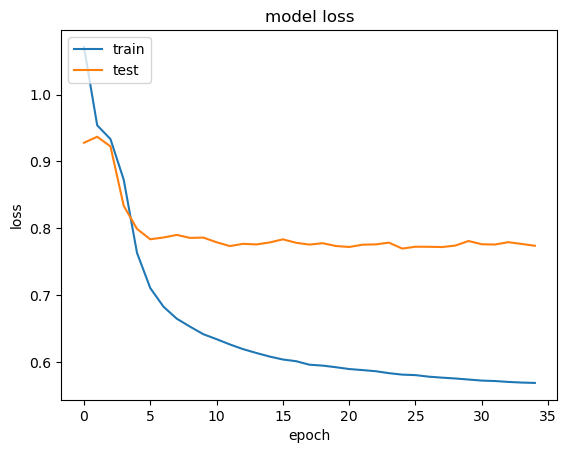

In [335]:
# Plot the training and validation loss

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

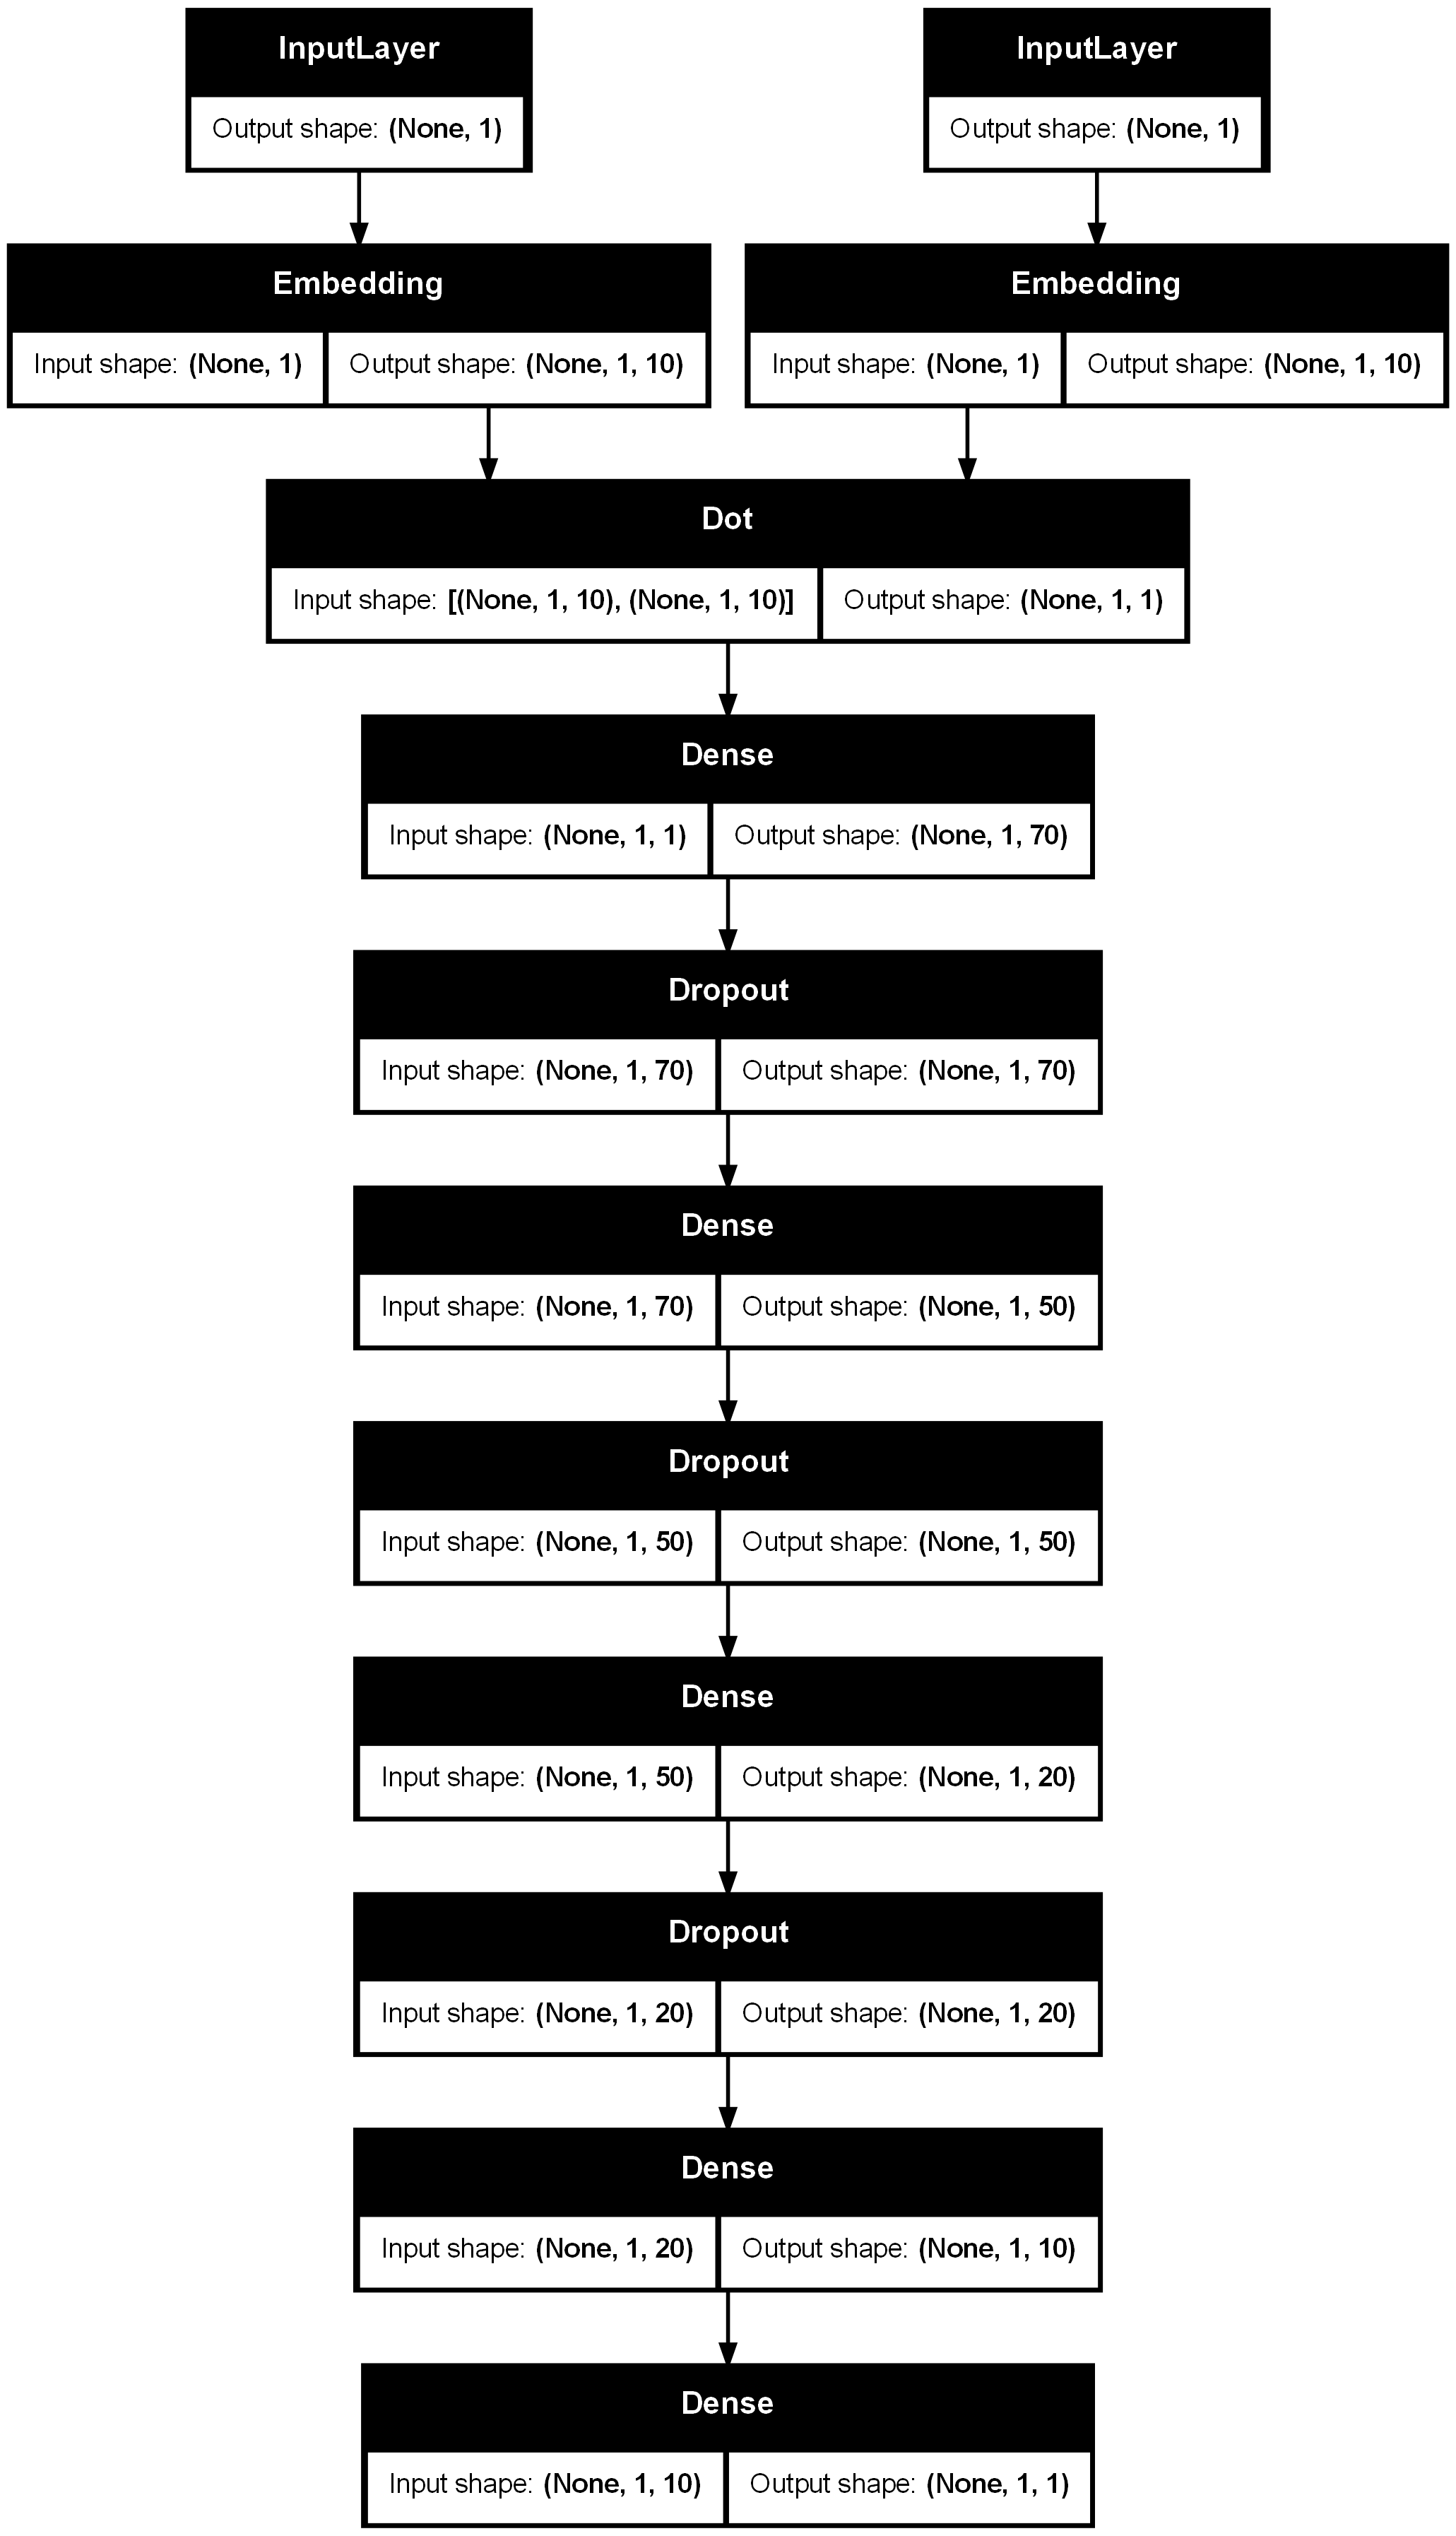

In [336]:
# Visualize the neural net
keras.utils.plot_model(model, show_shapes=True)

In [338]:
# Get Top N recommendations

MOVIE_EMBEDDING_LIST = []
MOVIE_EMBED_MAP = collections.defaultdict()

for _id in UNIQUE_MOVIE_IDS:
    emb = movie_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    MOVIE_EMBEDDING_LIST.insert(_id, val)
    MOVIE_EMBED_MAP[_id] = val

MOVIE_EMBEDDING_LIST[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

[array([ 0.14118499,  0.1639326 , -0.2015833 , -0.21472943,  0.22461085,
         0.1781841 ,  0.0538312 , -0.15917343,  0.20014368, -0.08891636],
       dtype=float32),
 array([ 0.23095971, -0.00837453, -0.33491158, -0.25663942,  0.04678651,
         0.1683921 ,  0.10523737, -0.10328809, -0.10703927,  0.1456712 ],
       dtype=float32),
 array([ 0.06176432, -0.13293627, -0.24075814, -0.23962218, -0.24237926,
        -0.08645125, -0.11838433, -0.13176557, -0.05596045,  0.20178199],
       dtype=float32),
 array([ 0.09280057,  0.09710704, -0.03332737, -0.19220641,  0.09416597,
        -0.04372288, -0.45517313, -0.04911929, -0.01486873, -0.31872776],
       dtype=float32),
 array([ 0.24327037,  0.3062657 , -0.11973877, -0.2289911 ,  0.10899141,
        -0.08936304, -0.26100287,  0.02252607, -0.1037376 , -0.07090874],
       dtype=float32),
 array([ 0.33310065,  0.06576148, -0.14050436, -0.00840029,  0.10373644,
        -0.2563067 , -0.17921454,  0.02861442,  0.05200535, -0.25981364],
   

In [339]:
knn_train_label = UNIQUE_MOVIE_IDS

In [340]:
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(MOVIE_EMBEDDING_LIST, knn_train_label)

KNeighborsClassifier(n_neighbors=11)

In [435]:
def recommend_movies(embedding, k=10):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=k)
    indices = indices.reshape(k,1)
    df_indices = pd.DataFrame(indices, columns = ['movie_id'])
    result = df_indices.merge(movielens,on='movie_id',how='inner',suffixes=['_u', '_m'])[['title', 'rating']]
    result = result.groupby('title').mean().reset_index()
    result = result.sort_values(by='rating', ascending=False)
    return result
    

In [425]:
TEST_USER_ID = 289

In [426]:

for genre in genre_cols:
    result = movielens[(movielens.user_id==TEST_USER_ID) & (movielens[genre]==1)].groupby(genre)['rating'].agg(['mean', 'count']).reset_index()
    result.columns = [genre, 'rating_mean', 'rating_count']
    display(result)
    print('\n')

,genre_unknown,rating_mean,rating_count


,Action,rating_mean,rating_count
0,1,3.415094,53


,Adventure,rating_mean,rating_count
0,1,3.27907,43


,Animation,rating_mean,rating_count
0,1,3.642857,14


,Children,rating_mean,rating_count
0,1,3.392857,28


,Comedy,rating_mean,rating_count
0,1,3.347826,46


,Crime,rating_mean,rating_count
0,1,2.666667,3


,Documentary,rating_mean,rating_count


,Drama,rating_mean,rating_count
0,1,3.44186,43


,Fantasy,rating_mean,rating_count
0,1,3.833333,6


,Film-Noir,rating_mean,rating_count
0,1,3.0,2


,Horror,rating_mean,rating_count
0,1,3.0,4


,Musical,rating_mean,rating_count
0,1,3.411765,17


,Mystery,rating_mean,rating_count
0,1,3.2,5


,Romance,rating_mean,rating_count
0,1,3.875,24


,Sci-Fi,rating_mean,rating_count
0,1,3.515152,33


,Thriller,rating_mean,rating_count
0,1,3.259259,27


,War,rating_mean,rating_count
0,1,3.636364,22


,Western,rating_mean,rating_count
0,1,3.0,2


In [401]:
movielens[(movielens.user_id==TEST_USER_ID) & (movielens.rating == 5.0)][['title', 'rating']].head(20)

,title,rating
57,"Sound of Music, The (1965)",5.0
499,Star Wars (1977),5.0
3500,"Lion King, The (1994)",5.0
7291,Weekend at Bernie's (1989),5.0
7547,E.T. the Extra-Terrestrial (1982),5.0
9940,Fantasia (1940),5.0
12703,Braveheart (1995),5.0
16445,"Empire Strikes Back, The (1980)",5.0
18019,Indiana Jones and the Last Crusade (1989),5.0
24914,Casablanca (1942),5.0


In [344]:
user_embedding = user_model.predict(np.array([TEST_USER_ID])).reshape(1,-1)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


In [437]:
recommend_movies(user_embedding)

,title,rating
7,Someone Else's America (1995),5.000000
0,Beautiful Thing (1996),3.965517
5,"Mrs. Brown (Her Majesty, Mrs. Brown) (1997)",3.947917
9,Spellbound (1945),3.933333
6,Normal Life (1996),3.000000
8,Something to Talk About (1995),2.769231
3,Feeling Minnesota (1996),2.625000
2,"Favor, The (1994)",2.000000
4,Here Comes Cookie (1935),2.000000
1,Being Human (1993),1.750000


The results are more biased towards Romance whereas user preferences also highlights Adventure & Sci-Fi. Our deep learning model could be more influenced by high rating for Comedy genre. This neural net model is a simple feedforward neural network designed specifically for collaborative filtering and we are not using any of the user/item features. There is still an opportunity to improve the recommendations by embedding additional user/item features and (or) moving towards Recurrent Neural Networks (RNNs) that are better equipped for handling sequential data. In fact, RNNs were a crucial stepping stone in the evolution of Transformer architecture and Large Language models.

For quickly experimenting with various neural net architecture and techniques, testing different activation functions, adding layers and tuning hyperparamters, check out [Librecommender](https://librecommender.readthedocs.io/en/latest/). LibRecommender provides an easy-to-use, high-level abstraction for recommender system focused on end-to-end recommendation process. It contains a training(libreco) and serving(libserving) module to let users quickly train and deploy different kinds of recommendation models. You can experiment with multiple different algorithms (DeepFM, RNN4Rec, TwoTower, etc.) quickly without a lot of overhead.

And if you are wondering, how Recommendation Systems are built and managed at large scale in companies like Amazon, check out this [blog](https://aws.amazon.com/blogs/big-data/generating-recommendations-at-amazon-scale-with-apache-spark-and-amazon-dsstne/) about DSSTNE from AWS. Amazon's Deep Scalable Sparse Tensor Network Engine (DSSTNE) is a high-performance deep learning framework specifically designed for recommendation systems. It excels at handling large-scale sparse datasets, making it ideal for real-world applications.

<a id='llm'></a>

#### 5. LLM based Recommender Systems

In [9]:
df = pd.read_csv('./data/netflix_titles.csv')

In [106]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [110]:
# subsetting data to Children, Family movies

df = df[df.listed_in == 'Children & Family Movies, Comedies']

In [112]:
def create_textual_representation(row):
    textual_representation = f"""Type: {row['type']},
Title: {row['title']},
Director: {row['director']},
Cast: {row['cast']},
Released: {row['release_year']},
Genres: {row['listed_in']},
Description: {row['description']}"""
    
    return textual_representation
    

In [114]:
df['textual_representation'] = df.apply(create_textual_representation, axis=1)

In [116]:
print(df['textual_representation'].values[0])

Type: Movie,
Title: Confessions of an Invisible Girl,
Director: Bruno Garotti,
Cast: Klara Castanho, Lucca Picon, Júlia Gomes, Marcus Bessa, Kiria Malheiros, Fernanda Concon, Gabriel Lima, Caio Cabral, Leonardo Cidade, Jade Cardozo,
Released: 2021,
Genres: Children & Family Movies, Comedies,
Description: When the clever but socially-awkward Tetê joins a new school, she'll do anything to fit in. But the queen bee among her classmates has other ideas.


In [118]:
## Setup Ollama parameters

embedding_size = 4096 #Mistral's default embedding size

# Initialize the vector indexing
index = faiss.IndexFlatL2(embedding_size)

# Initialize a embedding matrix with np.zeros
X = np.zeros((len(df['textual_representation']), embedding_size), dtype='float32')


In [120]:
for i, representation in enumerate(df['textual_representation']):
    if i % 20==0:
        print('Processed', str(i), 'instances')

    # Raise a POST request to Ollama running in the default localhost with your textual representation to get a response
    res = requests.post('http://localhost:11434/api/embeddings',
                        json = {'model' :'mistral',
                                'prompt' : representation
                               }
                       )
    # Get response in json format and filter for field 'embedding'
    embedding = res.json()['embedding']


    # replace zeros in embedding matrix with actual values
    X[i] = np.array(embedding)


# Add the embedding matrix into the vector database
index.add(X)

    
        

Processed 0 instances
Processed 20 instances
Processed 40 instances
Processed 60 instances
Processed 80 instances
Processed 100 instances
Processed 120 instances
Processed 140 instances
Processed 160 instances
Processed 180 instances
Processed 200 instances


In [123]:
faiss.write_index(index, 'index')

In [125]:
index = faiss.read_index('index')

In [127]:
df[df.title.str.contains('Spy Kids')]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,textual_representation
863,s864,Movie,Spy Kids: All the Time in the World,Robert Rodriguez,"Jessica Alba, Joel McHale, Rowan Blanchard, Ma...",United States,"May 20, 2021",2011,PG,88 min,"Children & Family Movies, Comedies",Twins Rebecca and Cecil spring into action wit...,"Type: Movie,\nTitle: Spy Kids: All the Time in..."
8074,s8075,Movie,Spy Kids,Robert Rodriguez,"Antonio Banderas, Carla Gugino, Alan Cumming, ...",United States,"April 1, 2019",2001,PG,88 min,"Children & Family Movies, Comedies",The tables are turned when pint-sized kids Car...,"Type: Movie,\nTitle: Spy Kids,\nDirector: Robe..."
8075,s8076,Movie,Spy Kids 2: The Island of Lost Dreams,Robert Rodriguez,"Antonio Banderas, Carla Gugino, Alexa PenaVega...",United States,"March 8, 2019",2002,PG,100 min,"Children & Family Movies, Comedies",Spy kids Carmen and Juni Cortez team up with t...,"Type: Movie,\nTitle: Spy Kids 2: The Island of..."
8076,s8077,Movie,Spy Kids 3: Game Over,Robert Rodriguez,"Daryl Sabara, Sylvester Stallone, Ricardo Mont...",United States,"April 1, 2019",2003,PG,83 min,"Children & Family Movies, Comedies",Carmen gets caught in a virtual reality game d...,"Type: Movie,\nTitle: Spy Kids 3: Game Over,\nD..."


In [165]:
search_movie = df[df.show_id =='s8075']
search_movie['textual_representation'].values[0]

'Type: Movie,\nTitle: Spy Kids,\nDirector: Robert Rodriguez,\nCast: Antonio Banderas, Carla Gugino, Alan Cumming, Teri Hatcher, Cheech Marin, Danny Trejo, Robert Patrick, Tony Shalhoub, Alexa PenaVega, Daryl Sabara,\nReleased: 2001,\nGenres: Children & Family Movies, Comedies,\nDescription: The tables are turned when pint-sized kids Carmen and Juni must rescue their secret-agent parents from the diabolical clutches of Alexander Minion.'

In [167]:
res = requests.post('http://localhost:11434/api/embeddings',
                        json = {'model' :'mistral',
                                'prompt' : search_movie['textual_representation'].values[0]
                               }
                       )

In [185]:
embedding = np.array([res.json()['embedding']], dtype = 'float32')

D, I = index.search(embedding, 11)

In [187]:
## Indices for the top 5 best matches
I

array([[180, 181,  16,  90, 112,  42,  18,  35,  30,  25, 132]],
      dtype=int64)

In [189]:
best_matches = np.array(df['textual_representation'])[I.flatten()]

In [191]:
# Report top 10 similar movies
for match in best_matches[1:]:
    print('\n')
    print(match)
    print('\n')



Type: Movie,
Title: Spy Kids 2: The Island of Lost Dreams,
Director: Robert Rodriguez,
Cast: Antonio Banderas, Carla Gugino, Alexa PenaVega, Daryl Sabara, Steve Buscemi, Mike Judge, Danny Trejo, Cheech Marin, Matt O'Leary, Emily Osment, Ricardo Montalban, Holland Taylor, Alan Cumming,
Released: 2002,
Genres: Children & Family Movies, Comedies,
Description: Spy kids Carmen and Juni Cortez team up with two other pint-size secret agents, Gary and Gerti Giggles, in order to take on an evil scientist.




Type: Movie,
Title: Spy Kids: All the Time in the World,
Director: Robert Rodriguez,
Cast: Jessica Alba, Joel McHale, Rowan Blanchard, Mason Cook, Jeremy Piven, Alexa PenaVega, Daryl Sabara, Ricky Gervais, Danny Trejo,
Released: 2011,
Genres: Children & Family Movies, Comedies,
Description: Twins Rebecca and Cecil spring into action with their retired secret agent stepmother to stop a time-manipulating mastermind and his nefarious plans.




Type: Movie,
Title: The Massively Mixed-Up Mid

We do see that the recommendations are well related to our prompt to find movies similar to "Spy Kids". Now, here is an example to witness the true power of LLMs that helps to alleviate data sparsity. This approach can provide recommendations even for an imaginary plot. This is particularly useful for solving cold start problems.

In [233]:
madeup_representation = """Type: Movie
Title: The kid who trained the dragon
Director: N/A
Cast: N/A
Released: N/A
Genres: Children & Family Movies, Comedies
Description: A dragon and a little kid become best friends and fight together to stop a villain."""

In [235]:
res = requests.post('http://localhost:11434/api/embeddings',
                        json = {'model' :'mistral',
                                'prompt' : madeup_representation
                               }
                       )

In [236]:
embedding = np.array([res.json()['embedding']], dtype = 'float32')

D, I = index.search(embedding, 11)

In [237]:
I

array([[ 20,  27,  49,  42, 156, 187,  82, 173,  99, 112,  93]],
      dtype=int64)

In [238]:
best_matches = np.array(df['textual_representation'])[I.flatten()]

In [239]:
# Report top 10 similar movies
for match in best_matches:
    print('\n')
    print(match)
    print('\n')



Type: Movie,
Title: Motu Patlu in Dragon's World,
Director: Suhas Kadav,
Cast: Saurav Chakrabarty,
Released: 2017,
Genres: Children & Family Movies, Comedies,
Description: A trip to a magical land of dragons turns action-packed when Motu, Patlu and friends must help protect the kingdom from an evil neighbor.




Type: Movie,
Title: Motu Patlu in Octupus World,
Director: Suhas Kadav,
Cast: Sourav Chakraborty, Vidit Kumar, Mayur Vyas, Mahendra Bhatnagar, Dishi Duggal, Nandkishore Pandey,
Released: 2017,
Genres: Children & Family Movies, Comedies,
Description: While returning a goldfish and an octopus from an aquarium to the sea, Motu and Patlu must also save the goldfish’s family from a mean, tentacled queen.




Type: Movie,
Title: Fukrey Boyzzz: Space Mein Fukrapanti,
Director: Avinash Walzade,
Cast: Viraaj Modgill, Jasleen Singh, Pooja Punjabi, Amit Deondi, Ketan Kava, Zeel Thakkar, Manish Bhavan, Viswanathan Sridhar,
Released: 2020,
Genres: Children & Family Movies, Comedies,
Descr